In [84]:
import pandas as pd
import numpy as np
# from featexp import get_univariate_plots

from sklearn.metrics import mean_absolute_error, median_absolute_error, explained_variance_score, mean_squared_error, r2_score
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import re 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns


In [158]:
# !pip install featexp shap
!pip freeze --local > /gdrive/'My Drive'/'Colab Notebooks'/'tr_challenge'/'requirements.txt'

In [2]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/'My Drive'/'Colab Notebooks'/'tr_challenge'
instruments = pd.read_csv('instruments.csv')
prices = pd.read_csv('prices.csv')
trades = pd.read_csv('trades.csv')

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/tr_challenge


In [ ]:
print(trades.shape)
trades.head()

(1104248, 7)


,Unnamed: 0,customer_id,execution_time,direction,execution_size,execution_price,instrument_id
0,0,4216,2020-01-02 20:00:00,BUY,1.0,8.49,59.0
1,1,1202,2020-01-06 11:00:00,BUY,10.0,8.92,59.0
2,2,4129,2020-01-07 18:00:00,BUY,4.0,8.90,59.0
3,3,4129,2020-01-07 18:00:00,SELL,4.0,8.88,59.0
4,4,4207,2020-01-20 10:00:00,BUY,1.0,8.83,59.0


In [ ]:
print(instruments.shape)
instruments.head()

(625, 5)


,instrument_id,sector_name,country_name,index_name,instrument_type
0,0,{Touristik},{Bermuda-Inseln},{SP500},STOCK
1,1,"{""""}","{""""}","{""""}",STOCK
2,2,{Genussmittel},{Kanada},"{""""}",STOCK
3,3,"{""Elektronik & Haushalt""}",{China},"{""""}",STOCK
4,4,{Finanzen},{Deutschland},{DAX},STOCK


In [ ]:
print(prices.shape)
prices.head()

(170446, 3)


,date,price,instrument_id
0,2020-12-10,2.5310,576
1,2020-01-01,1.2482,576
2,2020-02-01,1.3276,576
3,2020-03-01,1.2752,576
4,2020-04-01,1.2752,576


# Preprocess Data

In [3]:
trades['exec_date'] = trades.execution_time.apply(lambda x: x[:10])
trades['exec_date'] = pd.to_datetime(trades.exec_date)
trades = trades.loc[trades.execution_size > 0]
prices['date'] = pd.to_datetime(prices.date)


def parse_sector_name(sector_str):
    # split and remove all special chars in sectors, convert to lower cases and sets
    if type(sector_str) == str:
        sector_str = re.sub('[^A-Za-z0-9,]+', '', sector_str).lower()
        strings_list = set(sector_str.split(','))
        return strings_list
    else:
        return set()

instruments.sector_name = instruments.sector_name.apply(parse_sector_name)
instruments.country_name = instruments.country_name.apply(parse_sector_name)
instruments.index_name = instruments.index_name.apply(parse_sector_name)

In [4]:
#joining all three tables

df = trades.merge(instruments, left_on='instrument_id', right_on='instrument_id', how='left')
df = df.merge(prices, left_on=['instrument_id', 'exec_date'], right_on=['instrument_id', 'date'], how='left')
df = df.drop(['date', 'Unnamed: 0'], axis=1)
df['trade_vol'] = df.execution_price * df.execution_size
df['signed_trade_vol'] = df.apply(lambda row: -1 * row['trade_vol'] if row['direction'] != 'BUY' else row['trade_vol'], axis = 1)
print(df.isna().any())


# fill in prices, then dropping rows with nan size and prices and instrument_id (each of them only has one nan entry)

df['execution_price'] = df.execution_price.fillna(df.price)
df = df.loc[~df[['execution_size', 'execution_price', 'instrument_id']].isna().any(axis=1)]


customer_id         False
execution_time      False
direction           False
execution_size      False
execution_price     False
instrument_id        True
exec_date           False
sector_name          True
country_name         True
index_name           True
instrument_type      True
price                True
trade_vol           False
signed_trade_vol    False
dtype: bool


In [6]:
def calculate_metrics_cust(cust_id):
    cust_df = df.loc[df.customer_id == cust_id].sort_values(['execution_time', 'direction'])
    return get_features(cust_df)

def get_features(cust_df):
    inventory = {}
    closed_positions = {}
    realized_pl = 0
    
    # calculate realized p&l 
    for index, row in cust_df.iterrows():
        action = row['direction']
        size = round( row['execution_size'], 4)
        px = round( row['execution_price'], 4)
        security = row['instrument_id']
        
        if action == 'BUY' and security in inventory:
            closing_position = inventory[security]['size'] < 0

            if closing_position:
                # if avg_px of your shorted px is more than current px, then positive gains
                # if avg_px of shorted is less than current px, then negative gains
                realized_pl += abs(inventory[security]['size']) * inventory[security]['avg_px'] - size * px
            else:
                avg_px = (inventory[security]['avg_px'] * inventory[security]['size'] + size * px) / (size + inventory[security]['size'])
                inventory[security]['avg_px'] = avg_px

            inventory[security]['size'] += size


        elif action == 'BUY' and security not in inventory:
            inventory[security] = {}
            inventory[security]['size'] = size
            inventory[security]['avg_px'] = px

        elif action == 'SELL' and security not in inventory:
            inventory[security] = {}
            inventory[security]['size'] = -1 * size
            inventory[security]['avg_px'] = px

        elif action == 'SELL' and security in inventory:

            closing_position = inventory[security]['size'] > 0

            if closing_position:
                realized_pl += size * px - abs(inventory[security]['size']) * inventory[security]['avg_px']
                
            else:
                # print(inventory[security], size, px)
                avg_px = (inventory[security]['avg_px'] * abs(inventory[security]['size']) + size * px) / (size + abs(inventory[security]['size']))
                inventory[security]['avg_px'] = avg_px

            inventory[security]['size'] -= size
            
        else:
            print('invalid action')
            raise ValueError

    # consolidate gains, calculate overall performance and unrealized p&l
    latest_date = df.iloc[-1].exec_date
    latest_prices = prices.loc[prices.date == latest_date].set_index('instrument_id')

    unrealized_pl = 0
    market_cap_portfolio = 0
    for sec_id in inventory:
        holdings = inventory[sec_id]
        # print(holdings, latest_prices)
        latest_px = latest_prices.loc[sec_id]['price']
        unrealized_pl += (latest_px - holdings['avg_px']) * holdings['size']
        market_cap_portfolio += latest_px * abs(holdings['size'])
    performance = unrealized_pl + realized_pl


    # calculate instruments traded
    instruments_traded = cust_df.instrument_id.nunique()
    
    #calculate sectors_tradedd
    sectors_traded = set()
    for i in cust_df.sector_name:
        sectors_traded = sectors_traded.union(i)
    sectors_traded = len(sectors_traded)


    ##### additional metrics
    lifetime = (latest_date - cust_df.iloc[0].exec_date).days
    days_since_last_trade = (latest_date - cust_df.iloc[-1].exec_date).days 
    gaps = (cust_df.exec_date - cust_df.shift(1).exec_date).apply(lambda x: x.days)
    avg_time_gap = gaps.mean()
    std_time_gap = gaps.std()

    hhi = 0
    if round(market_cap_portfolio) != 0:
        for sec_id in inventory:
            holdings = inventory[sec_id]
            latest_px = latest_prices.loc[sec_id]['price']
            hhi += (latest_px * holdings['size'] / (market_cap_portfolio)) ** 2
    # if hhi > 1: print(hhi, market_cap_portfolio, inventory)
    # monthly avg volume, number of trades, and avg trade sizes
    dat = cust_df.groupby(cust_df['exec_date'].dt.month).agg({'trade_vol': ['sum', ], 'execution_size': 'count',}).sum(axis=0) / 12
    avg_vol = dat[0]
    num_trades = dat[1]



    return [unrealized_pl, realized_pl, performance, instruments_traded, 
            sectors_traded, market_cap_portfolio, 
            avg_vol, num_trades,
            lifetime, days_since_last_trade, avg_time_gap, std_time_gap, hhi]

def get_feature_target(cust_id):
    cust_df = df.loc[df.customer_id == cust_id].sort_values(['execution_time', 'direction'])
    features = get_features(cust_df.iloc[:3])
    start_date_target = cust_df.iloc[0].exec_date + pd.Timedelta("180 days")
    end_date_target = start_date_target + pd.Timedelta("30 days")

    if start_date_target >= pd.to_datetime('2020-12-01'): 
        # ('biased target, skipping this customer ')  
        return [np.nan for i in range(14) ]

    target_df = cust_df.loc[(cust_df.exec_date >= start_date_target) & (cust_df.exec_date < end_date_target)]

    target = target_df.shape[0]
    return features + [target]



# Part 1. Find rolling users for each day 

This part is done in Pandas since data is provided as CSV and I couldn't set up a SQL server locally on my PC due to compatibility issues. If an actual SQL query is needed for this part, I can convert the code into a query from Pandas/python below.

In [ ]:
# correcting incorrect hours (some have 25th hour stamp), truncating them to date only
# defining monthly as last 30 days


customers_per_day = trades.groupby('exec_date').agg({'customer_id': 'nunique', 'execution_time': 'count'})

customers_per_day['weekly_rolling_active_users'] = customers_per_day.customer_id.rolling('7D').sum()
customers_per_day['monthly_rolling_active_users'] = customers_per_day.customer_id.rolling('30D').sum()
customers_per_day = customers_per_day.rename({'execution_time': 'trades_vol'}, axis=1)
customers_per_day

,customer_id,trades_vol,weekly_rolling_active_users,monthly_rolling_active_users
exec_date,,,,
2020-01-02,532,989,532.0,532.0
2020-01-03,190,332,722.0,722.0
2020-01-06,239,400,961.0,961.0
2020-01-07,237,399,1198.0,1198.0
2020-01-08,259,459,1457.0,1457.0
...,...,...,...,...
2020-12-22,2101,3789,15818.0,58411.0
2020-12-23,2010,3531,10567.0,57880.0
2020-12-28,3386,6563,7497.0,53184.0


# Part 2. Analyze Trading Activity Data

**Metrics provided**:
- Cumulative customers
- Number of trades
- Volume of trades
- Average trade size
- Assets held by customers (at current value)



**Other metrics**:

Rationale - we want to prioritize customers who will be trading consistently on the TR platform, rather than customers who are likely to binge use TR for a short period of time, then never coming back again.


Proposed  metrics to capture the quality of customers:

- Avg cardinality instruments traded (measures diversity/breadth of securities, higher is better -> better user stickiness)


Additional metrics we could look into but I didn't have time to code them:
- Average customer lifetime (measures freshness or staleness of customers, lower is better - more new cusotmers)
- Days from last trade (measures platform loyalty/stickiness, lower is better)
- Average gap between trades (measures frequency, higher is better)
- Std between trades (measures consistency of trades, lower is better)
- Top 5 instrument traded as a % of daily vol (measures diversity/concentration of securities, lower is better -> more diverse)


In [ ]:
df.head()

,customer_id,execution_time,direction,execution_size,execution_price,instrument_id,exec_date,sector_name,country_name,index_name,instrument_type,price,trade_vol,signed_trade_vol
0,4216,2020-01-02 20:00:00,BUY,1.0,8.49,59.0,2020-01-02,"{""""}","{""""}","{""""}",DERIVATIVE,9.02,8.49,8.49
1,1202,2020-01-06 11:00:00,BUY,10.0,8.92,59.0,2020-01-06,"{""""}","{""""}","{""""}",DERIVATIVE,10.31,89.20,89.20
2,4129,2020-01-07 18:00:00,BUY,4.0,8.90,59.0,2020-01-07,"{""""}","{""""}","{""""}",DERIVATIVE,10.63,35.60,35.60
3,4129,2020-01-07 18:00:00,SELL,4.0,8.88,59.0,2020-01-07,"{""""}","{""""}","{""""}",DERIVATIVE,10.63,35.52,-35.52
4,4207,2020-01-20 10:00:00,BUY,1.0,8.83,59.0,2020-01-20,"{""""}","{""""}","{""""}",DERIVATIVE,8.84,8.83,8.83


In [ ]:
data_df = df.groupby('exec_date').agg({'customer_id': 'nunique', 
                             'execution_time': 'count', 
                             'trade_vol': ['mean', 'sum'], 
                             'signed_trade_vol': 'sum' , 
                             'instrument_id': 'nunique'}).rolling('14D').mean()
data_df.columns =  [' '.join(col).strip() for col in data_df.columns.values]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90c2be4990>,
      dtype=object)

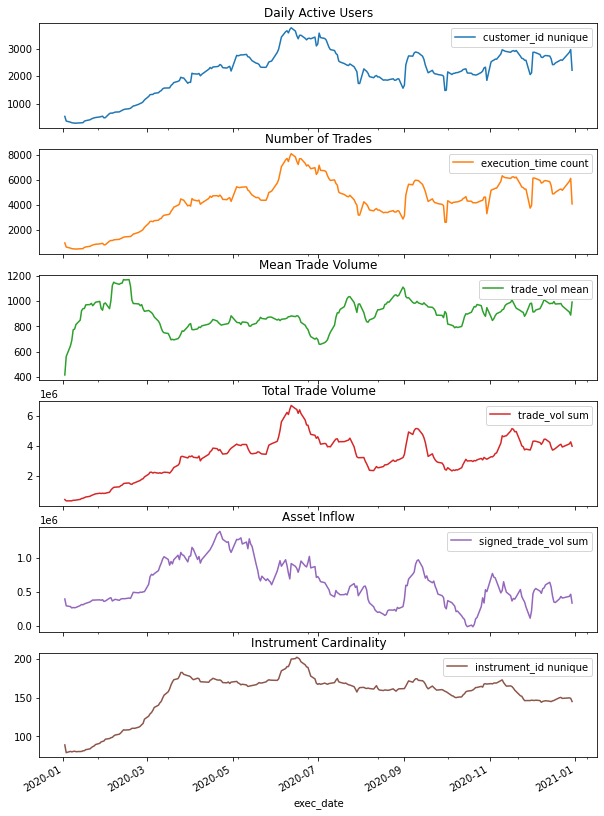

In [ ]:
data_df.plot(subplots=True, 
                    title=['Daily Active Users', 'Number of Trades', 'Mean Trade Volume', 'Total Trade Volume', 'Asset Inflow', 'Instrument Cardinality'], figsize=(10, 15))

## Insights from the graphs above
1. DAU, number of trades increased up until mid 2020, then exhibited a slight drop thereafter (could be seasonality)
2. Mean Trade Volumes have been more or less constant, meaning the new customers joining TR are more likely to be from the same cohorts as before
3. We're seeing mostly positive asset inflow into TR throughout 2020 - this is a good thing, since it means customers are parking their money at TR
4. Trade instrument cardinality increased up till March 2020 then dropped slightly towards the end -> needs more investigation, but could be due to new customers joining are less likely to be day traders trading a lot of stocks, but buy and hold customers 


# Part 3. Clustering Customers 

Calculate some basic features for each customer:
- Monthly volume, trades, and respective avg. trade size
- Performance - gains of each customer over time:
- realized profits, where there is a sell trade following the buy, and
- virtual profits, where there is no corresponding sell trade yet (value the open position at the last end of day
price)
- Distinct number of instruments they traded, and distinct number of sectors


Here I am gonna add a few additional metrics, including
- Customer Lifetime (measuring loyalty)
- Days since last trade (measuring activeness)
- Avg. gap in days between trades (measuring consistency)
- Herfindahl-Hirschman Index of portfolio (measuring concentration, closer to 0 is better -> more diverse securities)
- Top type of instrument type (derivative traders are more speculative -> less loyalty)

In [7]:
# generating features we discussed above
# assume shorting is allowed, judging by the fact that there are customers selling more than what they own

cols = ['unrealized_pl', 'realized_pl', 'performance', 'instruments_traded', 
            'sectors_traded', 'market_cap_portfolio', 
            'avg_vol', 'num_trades',
            'lifetime', 'days_since_last_trade', 'avg_time_gap', 'std_time_gap', 'hhi']

customer_features = pd.DataFrame(
    index = df.customer_id.unique(),
    columns = cols
)

sampled_cust_features = customer_features.sample(5000, random_state=0).apply(lambda x: calculate_metrics_cust(x.name), axis=1, result_type='expand')
sampled_cust_features.columns = cols
sampled_cust_features.fillna(0, inplace=True)

In [8]:
sampled_cust_features.describe()

,unrealized_pl,realized_pl,performance,instruments_traded,sectors_traded,market_cap_portfolio,avg_vol,num_trades,lifetime,days_since_last_trade,avg_time_gap,std_time_gap,hhi
count,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,669.189164,-4.449161e+03,-3.779972e+03,9.068200,7.332800,6230.573763,2329.023303,3.148400,267.606000,55.32440,15.979937,18.926190,0.417491
std,2894.951904,4.208741e+04,4.212966e+04,8.526106,5.190591,13183.726411,7399.876776,4.797293,58.113611,77.46344,23.154825,21.029512,0.318909
min,-49328.200081,-1.364075e+06,-1.344546e+06,1.000000,1.000000,0.000000,0.265417,0.083333,2.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,-3.406253e+02,-2.227403e+02,3.000000,3.000000,436.133989,105.962900,0.750000,226.000000,9.00000,4.514601,6.580345,0.168244
50%,126.454870,0.000000e+00,6.724615e+01,6.000000,6.000000,1985.603150,400.838513,1.666667,272.000000,20.00000,9.600000,12.392601,0.339183
75%,614.605003,1.600212e+01,4.423790e+02,12.000000,10.000000,6238.166906,1449.207177,3.583333,314.250000,62.00000,18.338235,23.007295,0.578868
max,74073.718081,3.134782e+05,3.813685e+05,73.000000,32.000000,200108.888000,152836.724083,79.666667,363.000000,363.00000,322.000000,198.697006,1.000000


## clustering 

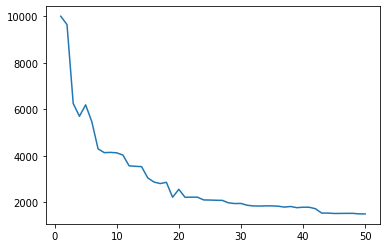

In [ ]:

# standardize features
x_transformed = StandardScaler().fit_transform(sampled_cust_features)


# elbow method, using within cluster sse as metric
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k,  random_state=0).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
          
        sse.append(curr_sse)
    return sse

wss = calculate_WSS(x_transformed, kmax=50)
sns.lineplot(x=range(1, 51), y=wss)

Judging from the SSE graph with the elbow method, the good number of cluster should be around 8-10.
To simplify our analysis, I'll use a cluster=4 here to try to get some basic insights.


In [ ]:
predicted = KMeans(n_clusters=4, random_state=0).fit_predict(x_transformed)

for i in range(4):
    idx = np.where(predicted == i)
    print(sampled_cust_features.iloc[idx][['unrealized_pl', 'market_cap_portfolio', 'instruments_traded', 'sectors_traded',
                                           'avg_vol', 'num_trades', 'hhi', 'days_since_last_trade', 'avg_time_gap', 'std_time_gap']].median())

unrealized_pl             2143.614779
market_cap_portfolio     28630.508975
instruments_traded          28.000000
sectors_traded              17.000000
avg_vol                  18009.899333
num_trades                  15.083333
hhi                          0.179358
days_since_last_trade        2.000000
avg_time_gap                 1.540426
std_time_gap                 3.611164
dtype: float64
unrealized_pl             56.560289
market_cap_portfolio     892.001610
instruments_traded         4.000000
sectors_traded             4.000000
avg_vol                  154.644949
num_trades                 0.833333
hhi                        0.504791
days_since_last_trade     30.000000
avg_time_gap              15.166667
std_time_gap              15.708044
dtype: float64
unrealized_pl             1641.462252
market_cap_portfolio     28463.923000
instruments_traded          15.000000
sectors_traded              12.000000
avg_vol                  79532.853494
num_trades                  32.833333
hh

- Group 1: Frequent traders with low turnover
- Group 2: Infrequent traders with low asset turnover, high concentration in a few securities
- Group 3: Power traders with high turnover, higher asset concentration than group 1
- Group 4: "average joes" who trade a few times a month

Further action items:
- More feature engineering, I ran out of time to do more of that
- Look more into higher number of clusters, might give different business insights 
- Try different clustering methods


# Bonus (Predict activity from first 3 trades)

- I'm going to use the same features from the last part, except we limit the feature generation to the first three transactions.
- Target -> number of trades in the 6th month after acquisition

In [137]:
cols = ['unrealized_pl', 'realized_pl', 'performance', 'instruments_traded', 
            'sectors_traded', 'market_cap_portfolio', 
            'avg_vol', 'num_trades',
            'lifetime', 'days_since_last_trade', 'avg_time_gap', 'std_time_gap', 'hhi', 'target']

future_preds = pd.DataFrame(
    index = df.customer_id.unique(),
    columns = cols
)

sampled_preds = future_preds.sample(10000, random_state=0).apply(lambda x: get_feature_target(x.name), axis=1, result_type='expand')
sampled_preds.columns = cols
sampled_preds = sampled_preds.loc[~sampled_preds.performance.isna()].fillna(0)
sampled_preds.shape

(8335, 14)

            target
count  8335.000000
mean      3.551650
std       7.216488
min       0.000000
25%       0.000000
50%       1.000000
75%       4.000000
max     121.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64f6141850>]],
      dtype=object)

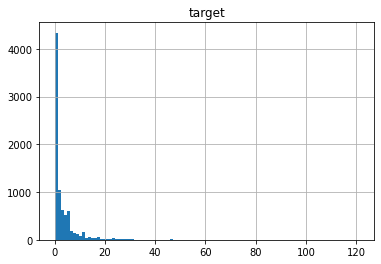

In [144]:
from sklearn.preprocessing import QuantileTransformer 

X = sampled_preds[cols[:-1]]
X_transformed = X
# X_transformed = StandardScaler().fit_transform(X)
y = sampled_preds[[cols[-1]]]
print(y.describe())
y.hist(bins=100)


Target variable is highly long tail, transforming it to something more usable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64f6f1d510>]],
      dtype=object)

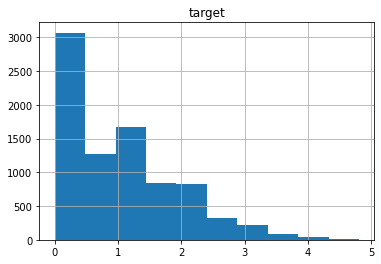

In [155]:
target = y.apply(np.log1p)
target.hist(bins=10)

In [157]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X_transformed, target, test_size=0.2, random_state=1)

print(X_train.shape, y_test.shape)

regr = RandomForestRegressor(max_depth=5, criterion='mse', n_estimators=200,  random_state=0)
model = regr.fit(X_train, y_train)

print('Training Set Performance')
y_pred = regr.predict(X_train)
y_true = y_train
print(
  f'R2: {r2_score(y_true, y_pred)}, MAE: {mean_absolute_error(y_true, y_pred)}, '
  f'  MSE: {mean_squared_error(y_true, y_pred)}, MedAE: {median_absolute_error(y_true, y_pred)}'
)

print('Validation Performance')
y_pred = regr.predict(X_test)
y_true = y_test
print(
  f'R2: {r2_score(y_true, y_pred, )}, MAE: {mean_absolute_error(y_true, y_pred)}, '
  f'  MSE: {mean_squared_error(y_true, y_pred)}, MedAE: {median_absolute_error(y_true, y_pred)}'
)

(6668, 13) (1667, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training Set Performance
R2: 0.123468768263153, MAE: 0.6986280648326826,   MSE: 0.782085125080709, MedAE: 0.636591436336734
Validation Performance
R2: 0.09335035386916124, MAE: 0.7248888186440673,   MSE: 0.8625764683828893, MedAE: 0.6651241946394543


## Comments on Bonus

- The performance isn't very good - R2 is only around 0.1. I ran out of time but we could look into it more. More feature engineering around customer behavior would definitely help
- We could do hyperparameter tuning to juice more performance out of RF, but feature engineering should come first.
- on average, a lot of customers don't make any transactions after 6 months (probably churned). But the distribution is quite long tail -> meaning there are a lot of power users who make a lot of transactions. These users are the revenue generators for TR (since TR makes money per transaction rather than by traded volume)
- Knowing the supplies of securities on TR and competitors would help in predicting as well.